# SWE spherical

### Load packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.cm as cm
import matplotlib.colors as mcolors 

from scipy.io import loadmat

import time

## Functions

In [2]:
# Define the global gravity constant
g = 9.81

def FluxX(Q):
    # Initialize F to the same shape as Q
    F = np.zeros_like(Q)

    # Compute the flux in the x-direction    
    F[0, :, :] = Q[1, :, :]
    F[1, :, :] = Q[1, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2
    F[2, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]

    return F


def FluxY(Q):
    # Initialize G to the same shape as Q
    G = np.zeros_like(Q)

    # Compute the flux in the y-direction
    G[0, :, :] = Q[2, :, :]
    G[1, :, :] = Q[1, :, :] * Q[2, :, :] / Q[0, :, :]
    G[2, :, :] = Q[2, :, :]**2 / Q[0, :, :] + 0.5 * g * Q[0, :, :]**2

    return G

def Lambdax(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity and wave speed
    u = Q[1, :, :] / Q[0, :, :]  # u = hu / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the x-direction
    L[0, :, :] = u - c
    L[1, :, :] = u
    L[2, :, :] = u + c

    return L

def Lambday(Q):
    # Initialize L to the same shape as Q
    L = np.zeros_like(Q)

    # Compute velocity in y-direction and wave speed
    v = Q[2, :, :] / Q[0, :, :]  # v = hv / h
    c = np.sqrt(g * Q[0, :, :])   # c = sqrt(g * h)

    # Characteristic velocities in the y-direction
    L[0, :, :] = v - c
    L[1, :, :] = v
    L[2, :, :] = v + c

    return L

def minmodarray(a, b):
    nVar, Nx, Ny = a.shape
    c = np.zeros((nVar, Nx, Ny))

    for i in range(nVar):
        # First condition: a * b > 0 and |a| < |b|
        logic1 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) < np.abs(b[i, :, :]))
        c[i, :, :] = a[i, :, :] * logic1
        
        # Second condition: a * b > 0 and |a| > |b|
        logic2 = (a[i, :, :] * b[i, :, :] > 0) & (np.abs(a[i, :, :]) > np.abs(b[i, :, :]))
        c[i, :, :] += b[i, :, :] * logic2

    return c

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F

def Rusanov(QL, QR, FL, FR, sL, sR):
    smax = np.maximum(np.abs(sL).max(), np.abs(sR).max())
    QL = QL.reshape(3,)
    QR = QR.reshape(3,)
    FL = FL.reshape(3,)
    FR = FR.reshape(3,)
    sL = sL.reshape(3,)
    sR = sR.reshape(3,)
    F = 0.5 * (FR + FL) - 0.5 * smax * (QR - QL)
    return F


In [3]:
def plot_initial_condition(X, Y, Z, THETA, PHI, H):
    # Create figure with 1 row and 3 columns
    fig = plt.figure(figsize=(18, 6))

    # First subplot: 3D surface plot
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, Z, facecolors=plt.cm.Blues(H), rstride=1, cstride=1, antialiased=True, shade=False)
    ax1.set_title('Initial condition')
    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    ax1.set_zlabel('z (m)')

    # Second subplot: 3D water height
    ax2 = fig.add_subplot(132, projection='3d')
    surf = ax2.plot_surface(THETA, PHI, H, cmap='Blues')
    ax2.set_title('Initial water height h (m)')
    ax2.set_xlabel(r'$\theta$ (rad)')
    ax2.set_ylabel(r'$\phi$ (rad)')
    ax2.set_zlabel('h (m)')
    fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=10)

    # Third subplot: Contour plot
    ax3 = fig.add_subplot(133)
    contour = ax3.contourf(THETA, PHI, H, cmap='Blues')
    ax3.set_title('Initial water height h (m)')
    ax3.set_xlabel(r'$\theta$ (rad)')
    ax3.set_ylabel(r'$\phi$ (rad)')
    ax3.grid()
    ax3.set_aspect('equal')
    fig.colorbar(contour, ax=ax3, shrink=0.5, aspect=10)

    # Adjust layout to avoid overlap
    plt.tight_layout()
    plt.show()

def plot_initial_condition_simple(theta, phi, H):
    # Plot the initial data in 3d and in contour
    cmap = 'Blues'
    # Prepare grid for 3D plot
    THETA, PHI = np.meshgrid(theta, phi)

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(121, projection='3d')

    surf = ax.plot_surface(THETA, PHI, H, cmap=cmap)
    ax.set_title(f'Initial water height h (m)')
    ax.set_xlabel(r'$\theta$ (rad)')
    ax.set_ylabel(r'$\phi$ (rad)')
    ax.set_zlabel('h (m)')
    ax.grid()
    #ax.set_aspect('equal')
    fig.colorbar(surf, ax=ax)

    ax2 = fig.add_subplot(122)
    surf = ax2.contourf(THETA, PHI, H, cmap=cmap)
    ax2.set_title(f'Initial water height h (m)')
    ax2.set_xlabel(r'$\theta$ (rad)')
    ax2.set_ylabel(r'$\phi$ (rad)')
    ax2.grid()
    ax2.set_aspect('equal')
    fig.colorbar(surf, ax=ax2)

    # Show the combined plot
    plt.tight_layout()
    plt.show()

## Inital conditions

In [23]:
# Global constants
g = 9.81  # gravity
N_theta = 200
N_phi = 100
thetaL, thetaR = 0, 2*np.pi # Longitude
phiL, phiR = 0, np.pi # Latitude
t = 0
tend = 0.5 # 1 
CFL = 0.8

d_theta = (thetaR - thetaL) / N_theta
d_phi = (phiR - phiL) / N_phi

# Define the grid
#theta = np.linspace(thetaL + d_theta / 2, thetaR - d_theta / 2, N_theta)
#phi = np.linspace(phiL + d_phi / 2, phiR - d_phi / 2, N_phi)
# Close the circle
theta = np.linspace(0, 2 * np.pi - d_theta, N_theta)  # Starting at 0 for theta
phi = np.linspace(0, np.pi - d_phi, N_phi)           # Starting at 0 for phi


# Center
theta_center = 3*np.pi/2
phi_center = np.pi/3

# Width
sigma = np.pi/16 # Assuming the same width in both directions

# Create the meshgrid
THETA, PHI = np.meshgrid(theta, phi)

r = 5

# Convert to Cartesian coordinates
X = r * np.sin(PHI) * np.cos(THETA)
Y = r * np.sin(PHI) * np.sin(THETA)
Z = r * np.cos(PHI)
print(f"Shape of X, Y, Z: {X.shape}")

# Initial 
Q = np.zeros((3, N_phi, N_theta))
Qnew = np.copy(Q)

def Gaussian_2D(theta, phi, theta_center, phi_center, sigma, h0=3):
    return 1 + h0 * np.exp( - ((theta - theta_center)**2/ (2*sigma**2) + (phi - phi_center)**2 / (2*sigma**2)))

H =  Gaussian_2D(THETA, PHI, theta_center, phi_center, sigma)
print(f"Shape of H: {H.shape}")

Q[0, :, :] = H


Shape of X, Y, Z: (100, 200)
Shape of H: (100, 200)


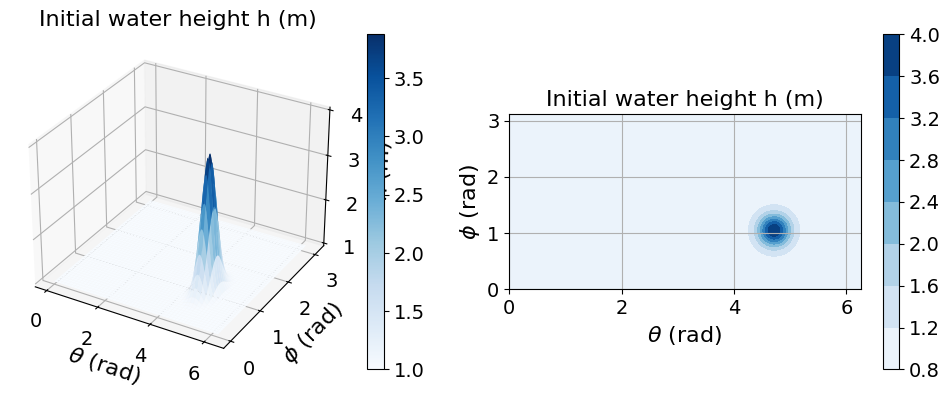

In [24]:
#plot_initial_condition(X, Y, Z, THETA, PHI, H)
plot_initial_condition_simple(theta, phi, H)

In [25]:
Q_all = []
Q_all.append(Q)
t_all = []
t_all.append(t)

# Start timer
start_time = time.time()

# Time loop
for n in range(100000):
    sx = Lambdax(Q)  # characteristic velocities in x-direction
    sy = Lambday(Q)  # characteristic velocities in y-direction
    ax = np.max(np.abs(sx))
    ay = np.max(np.abs(sy))
    
    dt = CFL / (ax / d_theta + ay / d_phi)
    if dt <= 0 or np.isnan(dt):
        raise ValueError('CFL condition not satisfied')
    if t + dt > tend:
        dt = tend - t
    if t >= tend:
        break

    # MUSCL part
    slopeX = np.zeros_like(Q)
    slopeY = np.zeros_like(Q)
    
    slopeX[:, :, 1:N_theta-1] = minmodarray(Q[:, :, 1:N_theta-1] - Q[:, :, 0:N_theta-2], Q[:, :, 2:N_theta] - Q[:, :, 1:N_theta-1])
    slopeY[:, 1:N_phi-1, :] = minmodarray(Q[:, 1:N_phi-1, :] - Q[:, 0:N_phi-2, :], Q[:, 2:N_phi, :] - Q[:, 1:N_phi-1, :])

    Qxm = Q - 0.5 * slopeX
    Qxp = Q + 0.5 * slopeX
    Qym = Q - 0.5 * slopeY
    Qyp = Q + 0.5 * slopeY

    Q_t = -(FluxX(Qxp) - FluxX(Qxm)) / d_theta - (FluxY(Qyp) - FluxY(Qym)) / d_phi
    Qxm += 0.5 * dt * Q_t
    Qxp += 0.5 * dt * Q_t
    Qym += 0.5 * dt * Q_t
    Qyp += 0.5 * dt * Q_t

    # Recompute physical fluxes and characteristic velocities for Rusanov flux
    fxm, fxp = FluxX(Qxm), FluxX(Qxp)
    gym, gyp = FluxY(Qym), FluxY(Qyp)
    
    sxm, sxp = Lambdax(Qxm), Lambdax(Qxp)
    sym, syp = Lambday(Qym), Lambday(Qyp)

    dtdx = dt / d_theta
    dtdy = dt / d_phi

    # Space loop
    for i in range(N_phi):
        for j in range(N_theta):
            # Numerical fluxes in X
            Fm = Rusanov(Qxp[:, (i - 1) % N_phi, j], Qxm[:, i, j], fxp[:, (i - 1) % N_phi, j], fxm[:, i, j], sxp[:, (i - 1) % N_phi, j], sxm[:, i, j])
            Fp = Rusanov( Qxp[:, i, j], Qxm[:, (i + 1) % N_phi, j], fxp[:, i, j], fxm[:, (i + 1) % N_phi, j], sxp[:, i, j], sxm[:, (i + 1) % N_phi, j] )

            # Numerical fluxes in Y
            Gm = Rusanov(Qyp[:, i, (j - 1) % N_theta], Qym[:, i, j], gyp[:, i, (j - 1) % N_theta], gym[:, i, j], syp[:, i, (j - 1) % N_theta], sym[:, i, j])
            Gp = Rusanov(Qyp[:, i, j], Qym[:, i, (j + 1) % N_theta], gyp[:, i, j], gym[:, i, (j + 1) % N_theta], syp[:, i, j], sym[:, i, (j + 1) % N_theta])

            # Finite volume update
            Qnew[:, i, j] = Q[:, i, j] - dtdx * (Fp - Fm) - dtdy * (Gp - Gm)
    

    # Update time and solution
    t += dt
    # Print t with 3 decimals
    print(f't = {t:.4f}')
    Qnew[0, :, :] = np.maximum(1e-10, Qnew[0, :, :])
    Q = np.copy(Qnew)
    Q_all.append(Q)
    t_all.append(t)

n = len(Q_all)
print(f'There are time steps: {n}')

# End timer
end_time = time.time()

# Print the time taken
elapsed_time = end_time - start_time
print(f'Time taken: {elapsed_time:.3f} seconds')


t = 0.0020
t = 0.0040
t = 0.0060
t = 0.0080
t = 0.0100
t = 0.0120
t = 0.0140
t = 0.0159
t = 0.0179
t = 0.0198
t = 0.0218
t = 0.0237
t = 0.0257
t = 0.0276
t = 0.0296
t = 0.0315
t = 0.0335
t = 0.0354
t = 0.0374
t = 0.0394
t = 0.0414
t = 0.0433
t = 0.0453
t = 0.0473
t = 0.0493
t = 0.0513
t = 0.0534
t = 0.0554
t = 0.0574
t = 0.0595
t = 0.0615
t = 0.0636
t = 0.0657
t = 0.0678
t = 0.0699
t = 0.0720
t = 0.0741
t = 0.0763
t = 0.0784
t = 0.0806
t = 0.0828
t = 0.0850
t = 0.0872
t = 0.0894
t = 0.0916
t = 0.0938
t = 0.0961
t = 0.0983
t = 0.1006
t = 0.1028
t = 0.1051
t = 0.1074
t = 0.1097
t = 0.1120
t = 0.1143
t = 0.1167
t = 0.1190
t = 0.1213
t = 0.1237
t = 0.1260
t = 0.1284
t = 0.1308
t = 0.1332
t = 0.1355
t = 0.1379
t = 0.1403
t = 0.1428
t = 0.1452
t = 0.1476
t = 0.1500
t = 0.1525
t = 0.1549
t = 0.1574
t = 0.1598
t = 0.1623
t = 0.1648
t = 0.1672
t = 0.1697
t = 0.1722
t = 0.1747
t = 0.1772
t = 0.1797
t = 0.1823
t = 0.1848
t = 0.1873
t = 0.1899
t = 0.1924
t = 0.1950
t = 0.1975
t = 0.2001
t = 0.2026

In [26]:
len(Q_all)

199

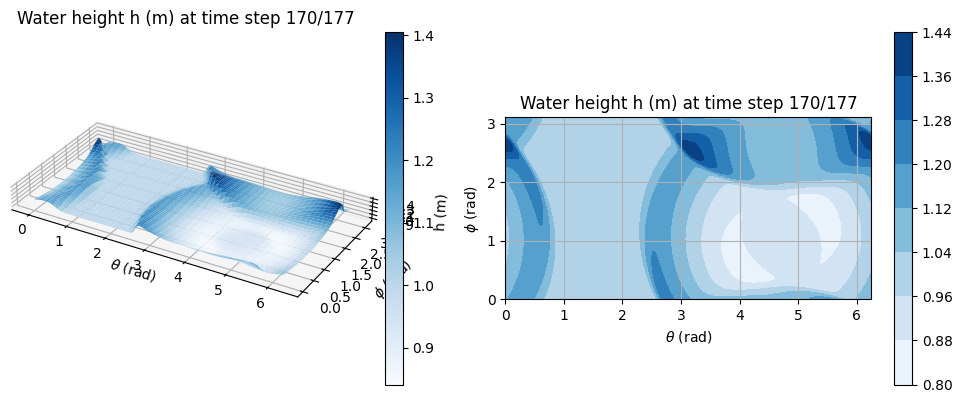

In [11]:
idx = 170

# Plot the initial data in 3d and in contour
cmap = 'Blues'
# Prepare grid for 3D plot
THETA, PHI = np.meshgrid(theta, phi)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, projection='3d')

surf = ax.plot_surface(THETA, PHI, Q_all[idx][0, :, :], cmap=cmap)
ax.set_title(f'Water height h (m) at time step {idx}/{n}')
ax.set_xlabel(r'$\theta$ (rad)')
ax.set_ylabel(r'$\phi$ (rad)')
ax.set_zlabel('h (m)')
ax.grid()
ax.set_aspect('equal')
fig.colorbar(surf, ax=ax)

ax2 = fig.add_subplot(122)
surf = ax2.contourf(THETA, PHI, Q_all[idx][0, :, :], cmap=cmap)
ax2.set_title(f'Water height h (m) at time step {idx}/{n}')
ax2.set_xlabel(r'$\theta$ (rad)')
ax2.set_ylabel(r'$\phi$ (rad)')
ax2.grid() 
ax2.set_aspect('equal')
fig.colorbar(surf, ax=ax2)

# Show the combined plot
plt.tight_layout()
plt.show()

In [14]:
plt.rc('font', size=14)  # Set default font size for all text
plt.rc('axes', titlesize=16)  # Set default size for axes titles
plt.rc('axes', labelsize=16)  # Set default size for axis labels

In [33]:
def plot_sphere_timesteps(Q_all, X, Y, Z, idx):
    # Create a figure with dynamic size based on the number of subplots
    n_plots = len(idx)
    fig = plt.figure(figsize=(7 * n_plots, 7))  # Adjust width based on the number of subplots

    # Loop through the indices and create subplots
    for i, i_idx in enumerate(idx):
        # Normalize the data for the color mapping for the current idx
        norm = mcolors.Normalize(vmin=Q_all[i_idx][0, :, :].min(), vmax=Q_all[i_idx][0, :, :].max())
        colors = cm.Blues(norm(Q_all[i_idx][0, :, :]))  # Map the data to the colormap

        # Add subplot (1 row, n_plots columns, plot number i+1)
        ax = fig.add_subplot(1, n_plots, i + 1, projection='3d')
        ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1, antialiased=True, shade=False)

        # Add a colorbar
        mappable = cm.ScalarMappable(cmap='Blues', norm=norm)  # Create a mappable object
        mappable.set_array([])  # Necessary for the colorbar
        cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)  # Add the colorbar
        cbar.set_label('h [m]')  # Label for the colorbar

        # Set titles and labels
        ax.set_title(f'Water height, h[m], at time step {i_idx}/{n}')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_zlabel('z [m]')
        # Set ticks
        ax.set_xticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticks([-1, 0, 1])
        ax.set_zticks([-1, 0, 1])
        ax.view_init(elev=22.5, azim=45+210)

    plt.tight_layout()  # Adjust the subplots to fit into the figure

    # Save the figure as a pdf file
    #plt.savefig('plots/sphere_projected_water_height_timesteps.pdf', bbox_inches='tight')

    plt.show()

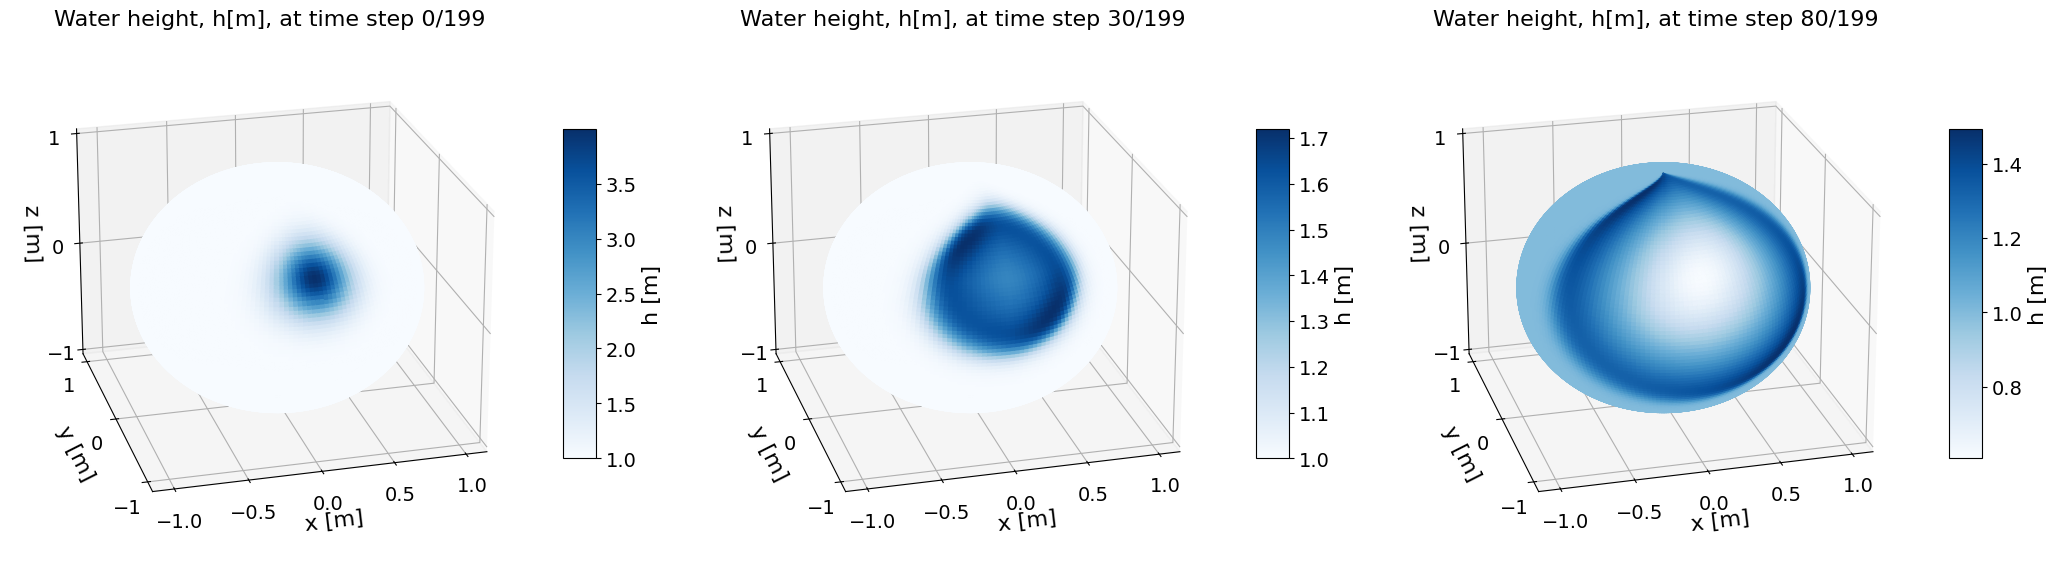

In [34]:
r = 1

# Convert to Cartesian coordinates
X = r * np.sin(PHI) * np.cos(THETA)
Y = r * np.sin(PHI) * np.sin(THETA)
Z = r * np.cos(PHI)

idx = [0, 30, 80]  # Example: three subplots with different timesteps
plot_sphere_timesteps(Q_all, X, Y, Z, idx)

### Make animation

In [14]:
N_phi, N_theta

(100, 200)

In [26]:
num_frames = len(Q_all)
idx = 0

ani = 0

if ani:
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')

    # Add a colorbar
    norm = mcolors.Normalize(vmin=Q_all[idx][0, :, :].min(), vmax=Q_all[idx][0, :, :].max())
    mappable = cm.ScalarMappable(cmap='Blues', norm=norm)  # Create a mappable object
    mappable.set_array([])  # Necessary for the colorbar
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Water Levels')  # Label for the colorbar

    def update(idx):
        ax.clear()

        # Normalize the data for the color mapping
        norm = mcolors.Normalize(vmin=Q_all[idx][0, :, :].min(), vmax=Q_all[idx][0, :, :].max())
        colors = cm.Blues(norm(Q_all[idx][0, :, :]))  # Map the data to the colormap

        # Plot on a 3D surface
        ax.plot_surface(X, Y, Z, facecolors=colors, rstride=1, cstride=1, antialiased=True, shade=False)

        ax.set_title(f'Water height, h[m], at time step {idx}/{n}')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        ax.set_zlabel('z [m]')

        # Set the view angle
        ax.view_init(elev=30, azim=45+210)

    # Save ani
    ani = FuncAnimation(fig, update, frames=range(num_frames), repeat=False)
    writer = PillowWriter(fps=10)
    ani.save(f'sphere_gaussian_FVM_17012025_N_phi={N_phi}, N_theta={N_theta}, t={tend}.gif', writer=writer)
    # save in html
    #ani.save(f'sphere_gaussian_FVM_17012025_N_phi={N_phi}, N_theta={N_theta}, t={tend}.html', writer='html')


### Make QR code

In [27]:
if 0:    
    import qrcode

    # URL of your HTML page with the GIF
    url = 'https://github.com/MelissaJessen/Shallow-Water-Equations-Animations/blob/main/sphere_gaussian_FVM_17012025_N_phi%3D100%2C%20N_theta%3D200%2C%20t%3D0.5.gif'

    # Generate QR code
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )

    # Add the URL to the QR code
    qr.add_data(url)
    qr.make(fit=True)

    # Create an image from the QR Code instance
    img = qr.make_image(fill_color="black", back_color="white")

    # Save the QR code
    img.save('QR/sphere_gaussian_FVM_17012025_qr.png')



### Other animations

In [12]:
num_frames= len(Q_all)

ani = 0
if ani:
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    cmap = 'Blues'

    def update(idx):
        ax.clear()
        ax.plot_surface(THETA, PHI, Q_all[idx][0, :, :], cmap=cmap)
        ax.set_title(f'Water levels at time {t_all[idx]:.2f} s')
        ax.set_xlabel(r'$\theta$ (rad)')
        ax.set_ylabel(r'$\phi$ (rad)')
        ax.set_zlabel('h (m)')
        ax.view_init(elev=30, azim=45+250) # Set the view angle
        ax.grid()
        #ax.set_aspect('equal')
        ax.set_xlim(0, 2*np.pi)
        ax.set_ylim(-np.pi/2, np.pi/2)
        ax.set_zlim([0, 4])
        #ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([2, 1, 1, 1]))  # Double scaling on Y (phi)

    # Save ani
    ani = FuncAnimation(fig, update, frames=range(num_frames), repeat=False)
    writer = PillowWriter(fps=10)
    ani.save('water_height_surface.gif', writer=writer)

In [13]:
num_frames= len(Q_all)

ani = 0
if ani:
    fig, ax = plt.subplots()

    def update(idx):
        ax.clear()
        ax.contourf(THETA, PHI, Q_all[idx][0, :, :], cmap='Blues')
        ax.set_title(f'Water height h (m) at time step {idx}/{n}')
        ax.set_xlabel(r'$\theta$ (rad)')
        ax.set_ylabel(r'$\phi$ (rad)')
        ax.grid()
        ax.set_aspect('equal')

    ani = FuncAnimation(fig, update, frames=range(num_frames), repeat=False)
    writer = PillowWriter(fps=10)
    ani.save('water_height_contour.gif', writer=writer)